## The Hilbert and Hilbert-Huang Transform

### Paul Anzel DATEDATEDATE

A problem with the Fourier transform (and related techniques) is that they're *stationary* methods--specifically, they assume that nothing actually changes in time, it's all just waves perpetually going in to and out of phase. A Fourier series of a music file will tell you that there's a lot of $A \flat$'s and middle $C$'s, but nothing about when they happen, and it assumes that, like some demented fool, you've decided to play "The Boys are Back in Town" over and over on to infinity--and that you've been playing that song since time immemorial. You can ignore this fact in practice, but it is a weird conceptual issue. 

Or, for a simpler case, assume that you've briefly turned on and off a light-switch. The Fourier transform assumes that the light is always emitting various frequencies, from before you were born until well past the collapse of civilization (and perhaps the demolishing of the light) but it *just so happens* that at all of these times the various frequencies were cancelling each other out until the magic moment that the light is turned on.

In [1]:
import numpy as np
import scipy as sp
from scipy.fftpack import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

from scipy.signal import hilbert, savgol_filter

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


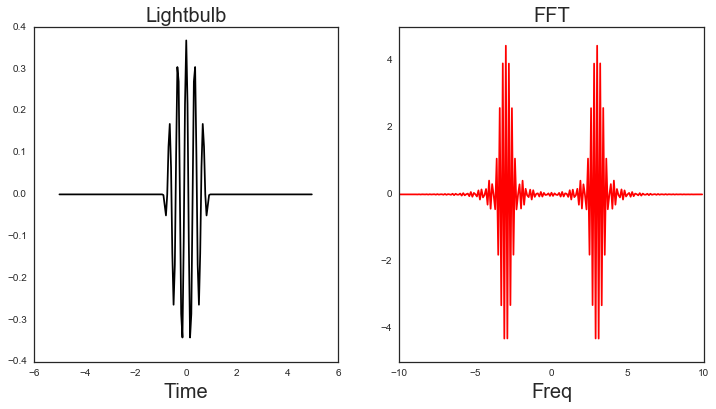

In [2]:
x_light = np.arange(-5, 5, 0.05)

# This is a bump function, so we have a nice turn off-and-on
_f = lambda x: np.exp(-1.0/(1.0-x*x))
f = lambda x: np.piecewise(x, [np.abs(x) < 1, np.abs(x) >= 1], [_f, 0.0])

y_light = np.cos(x_light*6*np.pi)
y_light = y_light*f(x_light)
y_fft = fft(y_light)
x_fft = fftfreq(len(x_light), 0.05)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].plot(x_light, y_light, color='k')
axes[0].set_title('Lightbulb', fontsize=20)
axes[0].set_xlabel('Time', fontsize=20)
axes[1].plot(fftshift(x_fft), fftshift(y_fft), color='r')
axes[1].set_xlabel('Freq', fontsize=20)
axes[1].set_title('FFT', fontsize=20)

This is weird. You'd think that, maybe if you filtered the light just right, you could cancel this out (you can't without breaking causality$^*$ but that's another issue) and see the light turning off and on.

There are various ways to deal with this; the most common is to window your signal (multiply it by a function that goes to 0 around some point $t$) and take transforms of the signal at different points in time (much like the song visualizers you might see in Winamp and iTunes), giving a *spectrogram*. Other technique include wavelet analysis and using the Wigner distribution function.

A final way, and our technique of interest here, is to take a Hilbert transform.

$^*$And this causality leads to the [Kramers-Kronig relations](https://en.wikipedia.org/wiki/Kramers%E2%80%93Kronig_relations), which is another Hilbert transform.

### Definition

The Hilbert transform of a function $f(t)$ is the transformation

$$ \mathcal{H}(f)(t) = \frac{1}{\pi} PV \int_{-\infty}^{\infty} \frac{f(\tau)}{t - \tau} d\tau $$ 

...so you're convolving your function $f(t)$ with the kernel $K(t) = 1/(\pi t$).

The *PV* in the above equation means Principal Value, which basically is telling you that for the part where $\tau$ is near $t$, you take an integral with $\tau$ going to $t - \epsilon$ and $t + \epsilon$ with the limit $\epsilon \rightarrow 0$. If you wanted to actually solve this for selected functions, you'd probably be using complex analysis with the Residue Theorem and talk about test functions going to 0 at infinity.

That is a problem for the mathematicians, and is not something we need to bother with. We can get some basic understanding by looking at tables of transforms [e.g. at Wikipedia](https://en.wikipedia.org/wiki/Hilbert_transform#Table_of_selected_Hilbert_transforms), and most critically understanding that the transform of a cosine gives a sine (at the same frequency) and the transform of a sine gives a negative cosine (same frequency).

Plus, we're going to be dealing with numeric data. So you're going to have some convolution kernel like

$$[..., -1/5, -1/4 -1/3, -1/2, -1, 0, 1, 1/2, 1/3, 1/4, 1/5, ...]/\pi$$

and you can ignore any weirdness about the $1/t$ blowup and stuff out at infinity.

Given a Hilbert transform of a function, one will then often create a function $\tilde{f}(t) = f(t) + i\mathcal{H}(f)(t)$, which is called the __analytic signal__.

### Okay, why do we care?

The cosine $\leftrightarrow$ sine bit of the Hilbert Transform and how we make the analytic signal looks a lot like using the Euler identity $\cos(\theta) + i\sin(\theta) = e^{i \theta}$. So we can think about this as writing our Analytic Signal as $\tilde{f}(t) = A(t)e^{i \theta(t) t}$. Then $A(t)$ gives us the __envelope__ of our signal (our signal is oscillating between the envelope) and $\frac{d}{dt}\theta(t)$ is our __instantaneous frequency__ (Specifically, angular frequency. Divide by $2\pi$ if you want normal frequency).$^*$ These are useful things to deal with.

$^*$Actually, this requres the time-scale that $A(t)$ changes at to be much slower than $e^{i \theta(t) t}$. This is based on something called the Bedrosian Theorem and some refinements to the basic ideas above are discussed [on page 6 here](http://www.msri.org/people/members/2008cc/Projects/Project_5B_Ice_Core_EMD/HuangWu_EMD_RevGeo_2008.pdf). But, for now, the above explanation is good enough.

#### Example: Chirp signal

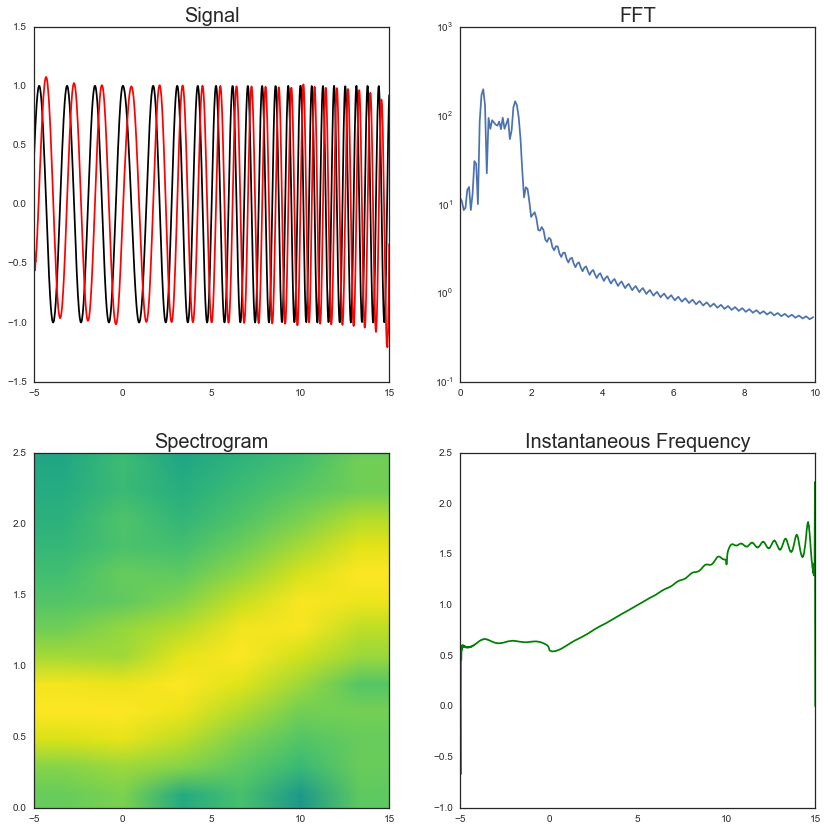

In [3]:
from scipy.signal import chirp

x_chirp = np.linspace(-5, 15, 1000)
dx = x_chirp[1]-x_chirp[0]
# chirp_index = np.logical_and(x_chirp > 0, x_chirp <= 10)
y_chirp = chirp(x_chirp, 0.5, 10, 1.5, method='linear')
y_chirp[x_chirp <= 0] = np.cos(4*x_chirp[x_chirp <= 0])
y_chirp[x_chirp >= 10] = np.cos(10*x_chirp[x_chirp >= 10]+np.pi/8)
fft_chirp = fft(y_chirp)
fftfreqs = fftfreq(len(x_chirp), dx)

ya_chirp = hilbert(y_chirp)

phase_chirp = np.angle(ya_chirp)
phase_chirp = np.unwrap(phase_chirp)
instant_freq = savgol_filter(phase_chirp, 3, 1, deriv=1, delta=dx, mode='mirror')/(2*np.pi)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axes[0,0].plot(x_chirp, y_chirp, color='k')
axes[0,0].plot(x_chirp, np.imag(ya_chirp), color='r')
axes[0,0].set_title('Signal', fontsize=20)
axes[0,1].semilogy(fftfreqs[:200], np.abs(fft_chirp[:200]))
axes[0,1].set_title('FFT', fontsize=20)
axes[1,1].plot(x_chirp, instant_freq, color='g')
axes[1,1].set_title('Instantaneous Frequency', fontsize=20)

axes[1,0].specgram(y_chirp, Fs=(1.0/dx), xextent=[-5, 15],cmap=plt.cm.viridis)
axes[1,0].set_ylim([0.0, 2.5])
axes[1,0].set_title('Spectrogram', fontsize=20)

The Fourier Transform clearly shows our frequencies going between 0.6 and 1.6, but doesn't tell us when. The spectrogram shows us the time at which we're at different frequencies, but is fuzzy. The Hilbert Transform, on the other hand, really clearly shows the frequencies at different times, though it has some issues at the boundaries (which could be addressed by mirroring the signal at the end points).

#### Example: Decaying signal

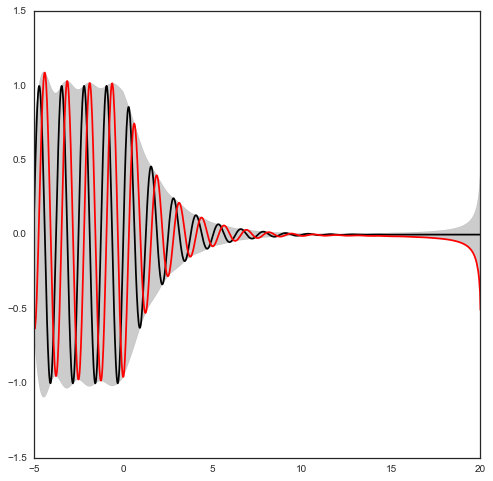

In [4]:
x_decay = np.linspace(-5, 20, 1000)
y_decay = np.exp(-0.5*x_decay)*np.sin(5*x_decay)
y_decay[x_decay < 0] = np.sin(5*x_decay[x_decay < 0])

ya_decay = hilbert(y_decay)
envelope = np.abs(ya_decay)

plt.figure(figsize=(8,8))
plt.plot(x_decay, y_decay, color='k')
plt.plot(x_decay, np.imag(ya_decay), color='r')
plt.fill_between(x_decay, -envelope, envelope, color='k', alpha=0.2)

Once again some weirdness at the boundaries (scipy calculates the signal by treating it as periodic, rather than giving the option to mirror) but the decay envelope starting at $t = 0$ is very clear. Since this weirdness-at-the-boundaries is getting to me, let's write our own function to do the mirroring.

In [5]:
def mirror_hilbert(x, reflect_x=True):
    # x should be a (N,) array, but in case you didn't do that
    x = x.ravel()
    N = len(x)
    if reflect_x:
        ref_term = -1
    else:
        ref_term = 1
    mirror_x = np.empty(3*N)
    mirror_x[:N] = ref_term*x[::-1]
    mirror_x[N:(2*N)] = x
    mirror_x[(2*N):] = ref_term*x[::-1]
    y = hilbert(mirror_x)
    ret_y = y[N:(2*N)]
    return ret_y

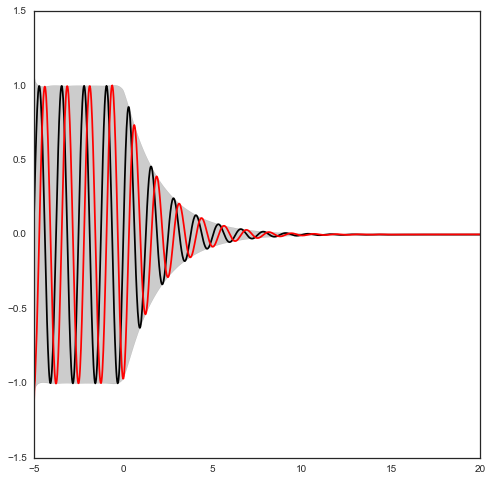

In [6]:
ya_decay2 = mirror_hilbert(y_decay, reflect_x=True)
envelope2 = np.abs(ya_decay2)

plt.figure(figsize=(8,8))
plt.plot(x_decay, y_decay, color='k')
plt.plot(x_decay, np.imag(ya_decay2), color='r')
plt.fill_between(x_decay, -envelope2, envelope2, color='k', alpha=0.2)

This is significantly cleaner. Note that I set the signal to be reflected in the y-axis for this example, as this more cleanly matches what the signal si doing at $t=-5$.

#### Example: Lightbulb

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


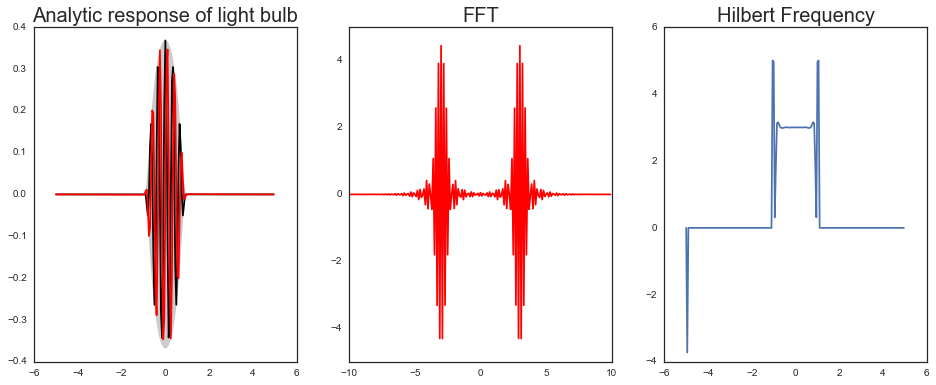

In [7]:
ya_light = hilbert(y_light)

light_phase = np.unwrap(np.angle(ya_light), discont=5)
envelope = np.abs(ya_light)
instant_freq = savgol_filter(light_phase, 3, 1, deriv=1, delta=x_light[1]-x_light[0], mode='mirror')/(2*np.pi)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
axes[0].plot(x_light, y_light, color='k')
axes[0].plot(x_light, np.imag(ya_light), color='r')
axes[0].fill_between(x_light, -envelope, envelope, color='k', alpha=0.2)
axes[0].set_title('Analytic response of light bulb', fontsize=20)
axes[1].plot(fftshift(x_fft), fftshift(y_fft), color='r')
axes[1].set_title('FFT', fontsize=20)
axes[2].plot(x_light, instant_freq)
axes[2].set_title('Hilbert Frequency', fontsize=20)

### Note:

Scipy has two Hilbert transform functions, [`scipy.fftpack.hilbert`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.fftpack.hilbert.html) and [`scipy.signal.hilbert`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.hilbert.html). It looks like the signal one is a bit more useful than the fftpack one.

### Properties of the Hilbert Transform and Analytic Signal

- $\mathcal{H}(\mathcal{H}(f(t)) = -f(t)$, up to a constant factor (and we'll get there in a bit...).
- In Fourier space, the Hilbert transform multiplies the Fourier transform by $i \times \text{sgn}(\nu)$. The transform to the analytic signal multiplies the Fourier transform by $2*\Theta(t)$ where $\Theta$ is the Heaviside function (0 at $t<0$, 1 at $t>0$). This means that we've basically cut out all of the negative frequency components of a signal.
- The instantaneous frequency **BEATS** the Gabor limit $\sigma_t \sigma_{\nu} \geq 1/4\pi$. If I was trying to use a spectrogram to figure out what frequency is happening right at the moment, I'd have to balance the width of the window--too wide and it's hard to tell exactly when something is happening, too narrow and I can't really distinguish between frequencies. We don't have that problem with the Hilbert transform.
- The Hilbert transform is scale invariant--if we have a function $f_b(t) = f(bt)$, its Hilbert transform $\mathcal{H}(f_b)(t) = \mathcal{H}(f)(bt)$. Hence, I can blithely apply the Hilbert transforms (as above) and not have to worry about the $\Delta x$ spacing.

### We run into some difficulties...

The "up to a constant factor" I mentioned in the first property ends up giving us some real headaches. For example, let's look at the function $f(t) = a + \sin(\pi t)$, where we adjust the constant factor $a$ (so we're looking at different reference values).

#### $a = 0$ (the case that works)

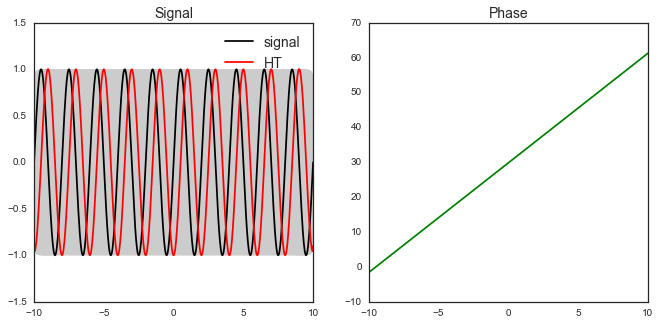

In [8]:
x_test = np.linspace(-10, 10, 600)
y_test = np.sin(np.pi*x_test) + 0.0
ya_test = mirror_hilbert(y_test)
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq0 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

#### $a = 0.5$ (the functions are offset slightly)

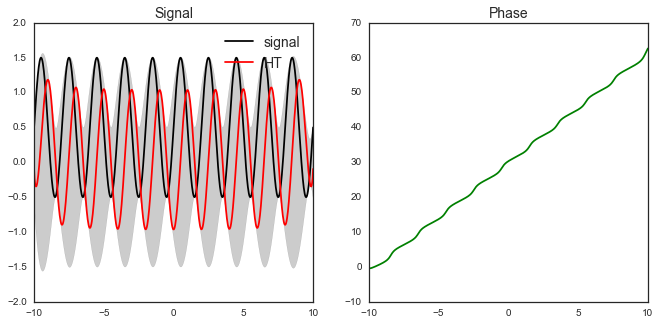

In [9]:
x_test = np.linspace(-10, 10, 600)
y_test = np.sin(np.pi*x_test) + 0.5
ya_test = mirror_hilbert(y_test, reflect_x=False)
# Needed to be set to false here due to constant term
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq03 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

#### $a = 1.2$ (we don't even hit 0)

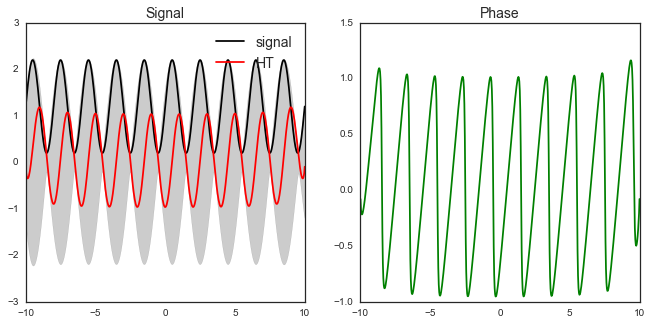

In [10]:
x_test = np.linspace(-10, 10, 600)
y_test = np.sin(np.pi*x_test) + 1.2
ya_test = mirror_hilbert(y_test, reflect_x=False)
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq12 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

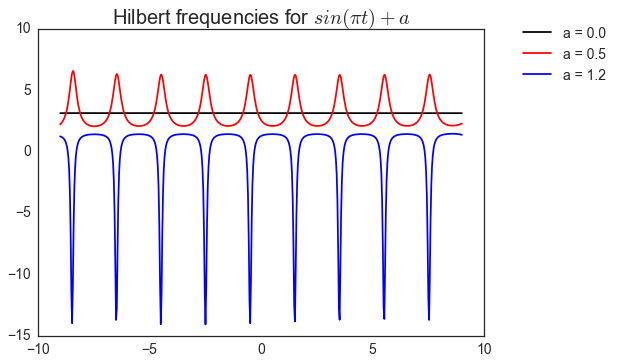

In [11]:

plt.plot(x_test[30:-30], instant_freq0[30:-30], 'k', label='a = 0.0')
plt.plot(x_test[30:-30], instant_freq03[30:-30], 'r', label='a = 0.5')
plt.plot(x_test[30:-30], instant_freq12[30:-30], 'b', label='a = 1.2')
plt.legend(bbox_to_anchor=(1.3, 1.05), fontsize=14)
plt.tick_params(labelsize=14)
plt.title(r'Hilbert frequencies for $sin(\pi t) + a$', fontsize=20)

#### Additionally, if we have two dominant frequencies superimposed, we also see odd behavior

$y = \sin(\pi x/2) + 0.5 \cos(\pi x)$

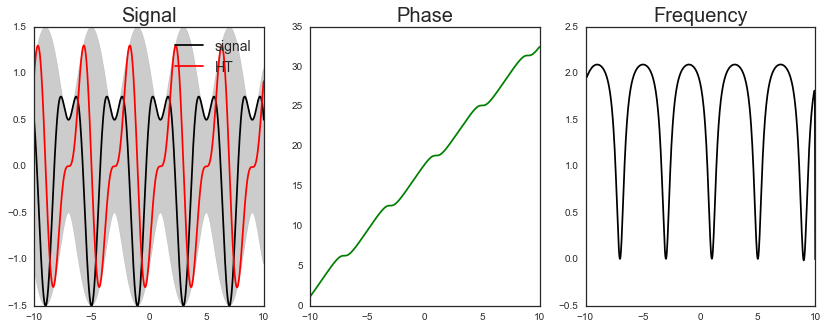

In [12]:
y_test2 = np.sin(np.pi*x_test/2) + 0.5*np.cos(np.pi*x_test)
ya_test2 = hilbert(y_test2)
# Signal is purely periodic, so not using mirror_hilbert

envelope = np.abs(ya_test2)
phaseterm = np.unwrap(np.angle(ya_test2))
instant_freq2 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5))

axes[0].plot(x_test, np.real(ya_test2), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test2), color='r', label='HT')
axes[0].fill_between(x_test, -envelope, envelope, color='k', alpha=0.2)
# axes[0].plot(x_test, envelope, color='k', alpha=0.6, linestyle=':', label='envelope')
# axes[0].plot(x_test, -envelope, color='k', alpha=0.6, linestyle=':')
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=20)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=20)
axes[2].plot(x_test, instant_freq2, color='k')
axes[2].set_title('Frequency', fontsize=20)

### The Hilbert-Huang Transform

These problems were addressed by Norden Huang in [this paper](http://rspa.royalsocietypublishing.org/content/454/1971/903). The fundamental problem is that the Hilbert Transform works well provided you've got a signal that is centered around 0, and with zero crossings between the minima and maxima.

So, we try and decompose our input signal into a collection of functions, called __Intrinsic Mode Functions__ (or IMFs) that *are* Hilbert-able.

The procedure works as follows:
- Take your signal, and compute two cubic splines--one that hits all the local maxima and one that hits all the local minima. These are our "signal envelope".
- Take the mean of these two splines and subtract it from the signal.
- The remaining signal is not necessarily Hilbert-able, but is closer to being so; we've centered the signal around 0 and the old minima and maxima should alternate on either side of 0, but our subtraction of the envelope mean may have caused new minima or maxima to occur.
- From this signal, repeat the splines-and-subtract-mean process again and again. There's a couple of different stopping rules in the literature, but basically you'll stop when either the signal does not change appreciably from one iteration to another (Cauchy stoppage rules) or the number of zero-crossings and extrema are within a value of 1 and stay the same after *S* iterations (S stoppage). Both rules are explained more [here](http://www.msri.org/people/members/2008cc/Projects/Project_5B_Ice_Core_EMD/HuangWu_EMD_RevGeo_2008.pdf).
- The signal you're left with is the first IMF, and gives good results under a Hilbert Transform.
- Subtract the first IMF from the data, and then repeat the whole splines-mean-repeat process to get the second IMF, third IMF, and so on.
- You'll stop getting IMFs when your remaining signal is either constant, monotonic or has at most one extremum. This is the residue, and is often thought of as the general trend.

This whole process is called the __Emperical Mode Decomposition__.

### Let's see this in action!

[One application](https://web.cs.dal.ca/~tt/CSCI690611/papers/plugin-huan_asmbi_2003.pdf) proposed by Huang and others is in financial data, which we know is definitely non-stationary and probably a poor candidate for simple Fourier analysis.

I've been sticking most of my IRA money into Vanguard Index Funds since 2013, so it's probably best for me to learn something about what's happening to it.

In [13]:
import pandas.io.data as web
import datetime as dt

start = dt.datetime(2013, 5, 1)
end = dt.datetime(2016, 5, 1)

vti = web.DataReader("VTI", "google", start, end)
# Blah blah blah pandas wants me to install pandas_datareader, this still works for now...
vti = vti['Close'] # I'll just keep opening prices

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [14]:
vti.head()

Date
2013-05-01    81.42
2013-05-02    82.27
2013-05-03    83.04
2013-05-06    83.36
2013-05-07    83.82
Name: Close, dtype: float64

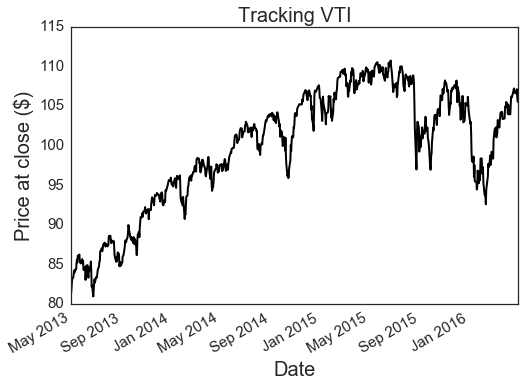

In [15]:
vti.plot(color='k', linewidth=2, fontsize=15)
plt.title("Tracking VTI", fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Price at close ($)", fontsize=20)

In [16]:
X0 = np.array(vti)
print(X0[:5])
dummy_t = np.arange(len(X0))  # So I don't have to futz with dates
vti_dates = vti.index

[ 81.42  82.27  83.04  83.36  83.82]


In [17]:
# Code to mirror both x and y in a nice way
def mirror_xy(x, y, numrep=1, invert=False):
    N = len(x)
    dx = x[1] - x[0]
    invert_term = -1 if invert else 1
    if numrep == 1:
        x_extend = np.empty(3*N)
        y_extend = np.empty(3*N)
        negx = np.arange(-N, 0)*dx + x[0]
        posx = np.arange(1, N + 1)*dx + x[-1]
        x_extend[:N] = negx
        x_extend[N:(2*N)] = x
        x_extend[(2*N):] = posx
        y_extend[:N] = y[::-1]*invert_term
        y_extend[N:(2*N)] = y
        y_extend[(2*N):] = y[::-1]*invert_term
        
    elif numrep == 2:
        x_extend = np.empty(5*N)
        y_extend = np.empty(5*N)
        negx = np.arange(-2*N, 0)*dx + x[0]
        posx = np.arange(1, 2*N + 1)*dx + x[-1]
        x_extend[:(2*N)] = negx
        x_extend[(2*N):(3*N)] = x
        x_extend[(3*N):] = posx
        y_extend[:(1*N)] = y
        y_extend[(1*N):(2*N)] = y[::-1]*invert_term
        y_extend[(2*N):(3*N)] = y
        y_extend[(3*N):(4*N)] = y[::-1]*invert_term
        y_extend[(4*N):] = y
    else:
        raise ValueError("Only set up for 1 or 2 reps")
    return x_extend, y_extend

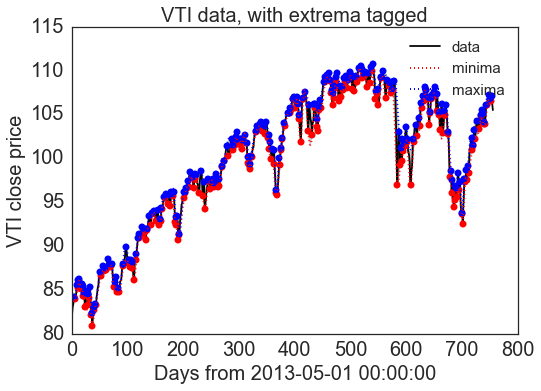

In [18]:
# I'm extending t and X0 so that we can extend the minima and maxima
# beyond the range and do cubic fits
ext_t, ext_X0 = mirror_xy(dummy_t, X0)

minima = sp.signal.argrelmin(ext_X0)
maxima = sp.signal.argrelmax(ext_X0)

minima_x = ext_X0[minima]
minima_t = ext_t[minima]

maxima_x = ext_X0[maxima]
maxima_t = ext_t[maxima]

minima_mask = np.logical_and(minima_t >= min(dummy_t), minima_t <= max(dummy_t))
maxima_mask = np.logical_and(maxima_t >= min(dummy_t), maxima_t <= max(dummy_t))

min_spline = sp.interpolate.interp1d(minima_t, minima_x, kind='cubic')
max_spline = sp.interpolate.interp1d(maxima_t, maxima_x, kind='cubic')

plt.plot(dummy_t, X0, color='k', label='data')
plt.plot(minima_t[minima_mask], minima_x[minima_mask], color='r', linewidth=0, marker='o')
plt.plot(maxima_t[maxima_mask], maxima_x[maxima_mask], color='b', linewidth=0, marker='o')
plt.plot(dummy_t, min_spline(dummy_t), color='r', linestyle=":", linewidth=2, label='minima')
plt.plot(dummy_t, max_spline(dummy_t), color='b', linestyle=":", linewidth=2, label='maxima')
plt.fill_between(dummy_t, min_spline(dummy_t), max_spline(dummy_t), color='k', alpha=0.2)
plt.xlabel("Days from %s" % start, fontsize=20)
plt.ylabel("VTI close price", fontsize=20)
plt.legend(fontsize=15)
plt.tick_params(labelsize=20)
plt.title("VTI data, with extrema tagged", fontsize=20)

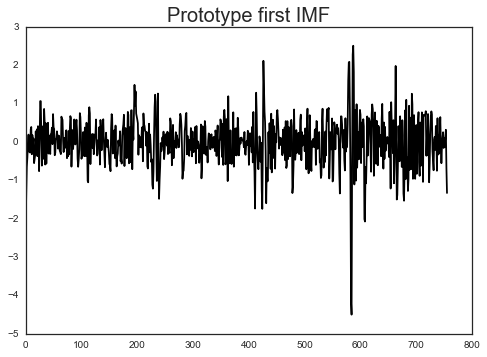

In [19]:
m1 = (max_spline(dummy_t) + min_spline(dummy_t))/2
h1 = X0 - m1

plt.plot(dummy_t, h1, color='k')
plt.title("Prototype first IMF", fontsize=20)

This is much more centered around 0, but we should run this process a few more times to see it settle.

In [20]:
def HHT_IMF_prototype(t, x, Niter=5, verbose=False):
    N = len(t)
    out_x = np.zeros((N, Niter))
    for idx in range(Niter):
        if verbose:
            print('Running %d of %d' % (idx + 1, Niter))
        try:
            ext_t, ext_x = mirror_xy(t, x)
            minima = sp.signal.argrelmin(ext_x)
            maxima = sp.signal.argrelmax(ext_x)
            minima_x = ext_x[minima]
            minima_t = ext_t[minima]
            maxima_x = ext_x[maxima]
            maxima_t = ext_t[maxima]
            min_spline = sp.interpolate.interp1d(minima_t, minima_x, kind='cubic')
            max_spline = sp.interpolate.interp1d(maxima_t, maxima_x, kind='cubic')
        except:
            # We try and do this with an extra reflection
            if verbose:
                print('Trying with extended region')
            ext_t, ext_x = mirror_xy(t, x, numrep=2)
            minima = sp.signal.argrelmin(ext_x)
            maxima = sp.signal.argrelmax(ext_x)
            minima_x = ext_x[minima]
            minima_t = ext_t[minima]
            maxima_x = ext_x[maxima]
            maxima_t = ext_t[maxima]
            min_spline = sp.interpolate.interp1d(minima_t, minima_x, kind='cubic')
            max_spline = sp.interpolate.interp1d(maxima_t, maxima_x, kind='cubic') 
        env_mean = (min_spline(t) + max_spline(t))/2
        x = x - env_mean
        out_x[:, idx] = x
    return out_x

In [21]:
h1_series = HHT_IMF_prototype(dummy_t, h1, Niter=5, verbose=True)

Running 1 of 5
Running 2 of 5
Running 3 of 5
Running 4 of 5
Running 5 of 5


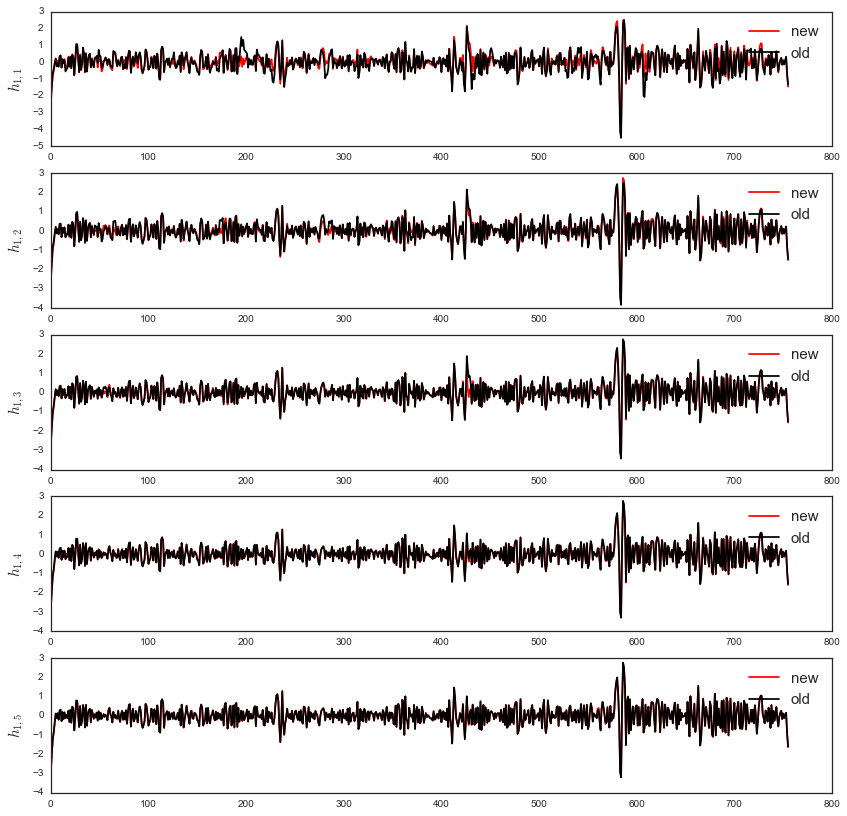

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14,14))
axes[0].plot(dummy_t, h1_series[:,0], color='r', label='new')
axes[0].plot(dummy_t, h1, color='k', label='old')
axes[0].legend(fontsize=15)
axes[0].set_ylabel(r"$h_{1,1}$", fontsize=15)
axes[1].plot(dummy_t, h1_series[:,1], color='r', label='new')
axes[1].plot(dummy_t, h1_series[:,0], color='k', label='old')
axes[1].legend(fontsize=15)
axes[1].set_ylabel(r"$h_{1,2}$", fontsize=15)
axes[2].plot(dummy_t, h1_series[:,2], color='r', label='new')
axes[2].plot(dummy_t, h1_series[:,1], color='k', label='old')
axes[2].legend(fontsize=15)
axes[2].set_ylabel(r"$h_{1,3}$", fontsize=15)
axes[3].plot(dummy_t, h1_series[:,3], color='r', label='new')
axes[3].plot(dummy_t, h1_series[:,2], color='k', label='old')
axes[3].legend(fontsize=15)
axes[3].set_ylabel(r"$h_{1,4}$", fontsize=15)
axes[4].plot(dummy_t, h1_series[:,4], color='r', label='new')
axes[4].plot(dummy_t, h1_series[:,3], color='k', label='old')
axes[4].legend(fontsize=15)
axes[4].set_ylabel(r"$h_{1,5}$", fontsize=15)

By the 5th iteration, it looks like the signal is pretty static, so we'll say that we've settled on the first IMF ($h_{1,5}$).

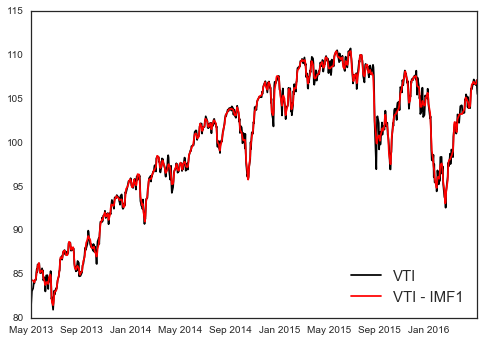

In [23]:
IMF1 = h1_series[:,-1]
X1 = X0 - IMF1

plt.plot(vti_dates, X0, color='k', label='VTI')
plt.plot(vti_dates, X1, color='r', label='VTI - IMF1')
plt.legend(fontsize=15, loc=4)

So the remaining signal has much of the high-frequency stuff filtered out.

Repeating this again...

In [24]:
h2_series = HHT_IMF_prototype(dummy_t, X1, Niter=6, verbose=True)

Running 1 of 6
Running 2 of 6
Running 3 of 6
Running 4 of 6
Running 5 of 6
Running 6 of 6


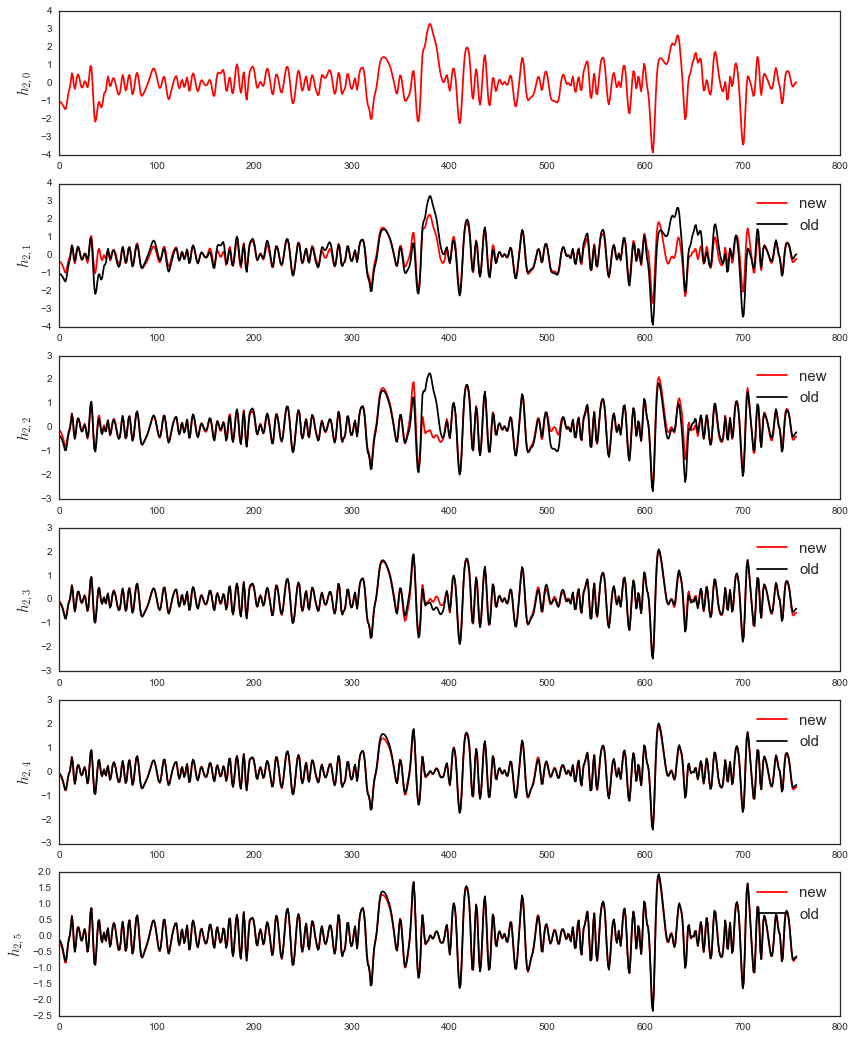

In [25]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(14,18))
axes[0].plot(dummy_t, h2_series[:,0], color='r')
axes[0].set_ylabel(r"$h_{2,0}$", fontsize=15)
axes[1].plot(dummy_t, h2_series[:,1], color='r', label='new')
axes[1].plot(dummy_t, h2_series[:,0], color='k', label='old')
axes[1].legend(fontsize=15)
axes[1].set_ylabel(r"$h_{2,1}$", fontsize=15)
axes[2].plot(dummy_t, h2_series[:,2], color='r', label='new')
axes[2].plot(dummy_t, h2_series[:,1], color='k', label='old')
axes[2].legend(fontsize=15)
axes[2].set_ylabel(r"$h_{2,2}$", fontsize=15)
axes[3].plot(dummy_t, h2_series[:,3], color='r', label='new')
axes[3].plot(dummy_t, h2_series[:,2], color='k', label='old')
axes[3].legend(fontsize=15)
axes[3].set_ylabel(r"$h_{2,3}$", fontsize=15)
axes[4].plot(dummy_t, h2_series[:,4], color='r', label='new')
axes[4].plot(dummy_t, h2_series[:,3], color='k', label='old')
axes[4].legend(fontsize=15)
axes[4].set_ylabel(r"$h_{2,4}$", fontsize=15)
axes[5].plot(dummy_t, h2_series[:,5], color='r', label='new')
axes[5].plot(dummy_t, h2_series[:,4], color='k', label='old')
axes[5].legend(fontsize=15)
axes[5].set_ylabel(r"$h_{2,5}$", fontsize=15)

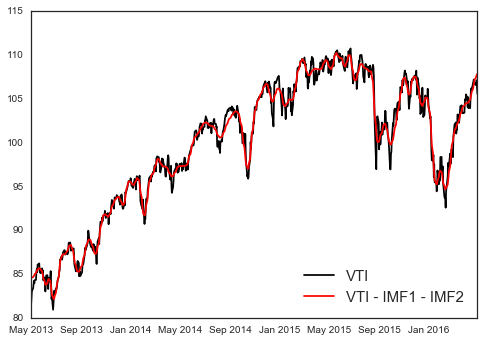

In [26]:
IMF2 = h2_series[:,-1]
X2 = X1 - IMF2

plt.plot(vti_dates, X0, color='k', label='VTI')
plt.plot(vti_dates, X2, color='r', label='VTI - IMF1 - IMF2')
plt.legend(fontsize=15, loc=4)

I want to automate this process more, so I'll now use the S stoppage rule (number of extrema and zero-crossings within one of each other, number of extrema and zero crossings does not change for 5 iterations).

In [27]:
def calculate_next_IMF(X_i, S_finish=5, maxiter=25, extra_verbose=False):
    print("Calulating h_i0")
    t = np.arange(len(X_i))
    S_accum = 0
    h_i = HHT_IMF_prototype(t, X_i, Niter=1).ravel()

    # Find number of maxima and zero crossings
    minima = sp.signal.argrelmin(h_i)
    if isinstance(minima, tuple):
        minima = minima[0]
    maxima = sp.signal.argrelmax(h_i)[0]
    if isinstance(maxima, tuple):
        maxima = maxima[0]
    # argrel doesn't pick points on the boundaries, fortunately
    zerocrossdown = np.logical_and(h_i[:-1] >= 0, h_i[1:] < 0)
    zerocrossup = np.logical_and(h_i[:-1] <= 0, h_i[1:] > 0)
    
    numextrema = len(minima) + len(maxima)
    numzeros = sum(zerocrossdown) + sum(zerocrossup)
    old_numextrema = numextrema
    old_numzeros = numzeros
    
    idx = 1
    while S_accum < S_finish:
        print("Beginning iter %s" % idx)
        
        h_i = HHT_IMF_prototype(t, h_i, Niter=1, verbose=extra_verbose).ravel()
        
        minima = sp.signal.argrelmin(h_i)
        if isinstance(minima, tuple):
            minima = minima[0]
        maxima = sp.signal.argrelmax(h_i)
        if isinstance(maxima, tuple):
            maxima = maxima[0]
        zerocrossdown = np.logical_and(h_i[:-1] >= 0, h_i[1:] < 0)
        zerocrossup = np.logical_and(h_i[:-1] <= 0, h_i[1:] > 0)
    
        numextrema = len(minima) + len(maxima)
        numzeros = sum(zerocrossdown) + sum(zerocrossup)
        
        test1 = np.abs(numextrema - numzeros) <= 1
        test2 = numextrema == old_numextrema
        test3 = numzeros == old_numzeros
        
        old_numextrema = numextrema
        old_numzeros = numzeros
        
        if test1 and test2 and test3:
            print("Passed S")
            S_accum += 1
        else:
            print("Failed S")
            S_accum = 0
        if idx == maxiter:
            print("Reached maxiter")
            break
        idx += 1
    return h_i, idx

In [28]:
# Redoing the calc of IMF1 and 2 above, since it's difficult to check IMF1 to ensure we're stopping appropriately.
IMF1, _ = calculate_next_IMF(X0)
X1 = X0 - IMF1
IMF2, _ = calculate_next_IMF(X1)
X1 = X0 - IMF1

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Failed S
Beginning iter 3
Failed S
Beginning iter 4
Failed S
Beginning iter 5
Passed S
Beginning iter 6
Failed S
Beginning iter 7
Passed S
Beginning iter 8
Passed S
Beginning iter 9
Passed S
Beginning iter 10
Failed S
Beginning iter 11
Failed S
Beginning iter 12
Passed S
Beginning iter 13
Passed S
Beginning iter 14
Passed S
Beginning iter 15
Passed S
Beginning iter 16
Passed S
Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Failed S
Beginning iter 3
Failed S
Beginning iter 4
Failed S
Beginning iter 5
Failed S
Beginning iter 6
Failed S
Beginning iter 7
Failed S
Beginning iter 8
Failed S
Beginning iter 9
Failed S
Beginning iter 10
Failed S
Beginning iter 11
Failed S
Beginning iter 12
Passed S
Beginning iter 13
Passed S
Beginning iter 14
Failed S
Beginning iter 15
Failed S
Beginning iter 16
Passed S
Beginning iter 17
Failed S
Beginning iter 18
Failed S
Beginning iter 19
Failed S
Beginning iter 20
Passed S
Beginning iter

In [29]:
IMF3, _ = calculate_next_IMF(X2)

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Passed S
Beginning iter 3
Passed S
Beginning iter 4
Passed S
Beginning iter 5
Passed S
Beginning iter 6
Passed S


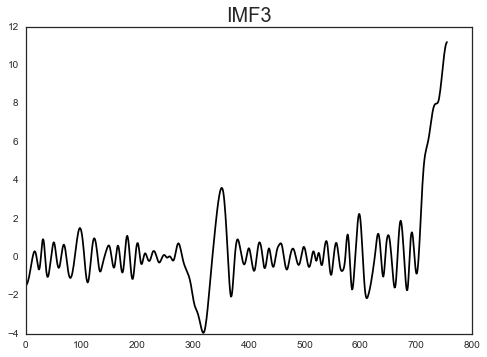

In [30]:
plt.plot(dummy_t, IMF3, color='k')
plt.title("IMF3", fontsize=20)

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Failed S
Beginning iter 3
Failed S
Beginning iter 4
Passed S
Beginning iter 5
Passed S
Beginning iter 6
Passed S
Beginning iter 7
Passed S
Beginning iter 8
Passed S


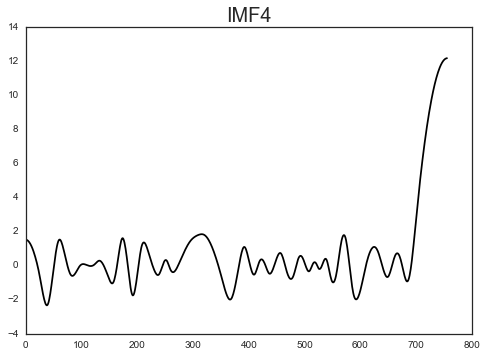

In [31]:
X3 = X2 - IMF3
IMF4, _ = calculate_next_IMF(X3)
plt.plot(dummy_t, IMF4, color='k')
plt.title("IMF4", fontsize=20)

Calulating h_i0
Beginning iter 1
Failed S
Beginning iter 2
Passed S
Beginning iter 3
Passed S
Beginning iter 4
Passed S
Beginning iter 5
Passed S
Beginning iter 6
Passed S


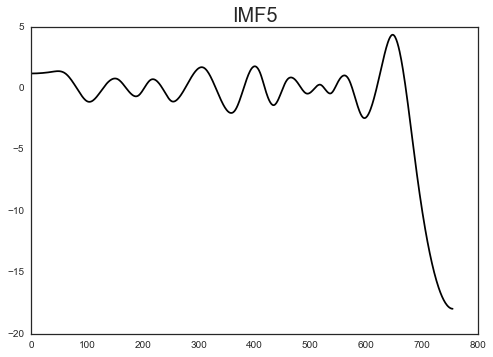

In [32]:
X4 = X3 - IMF4
IMF5, _ = calculate_next_IMF(X4)
plt.plot(dummy_t, IMF5, color='k')
plt.title("IMF5", fontsize=20)

(array([], dtype=int64),)
(array([523]),)
(756,)


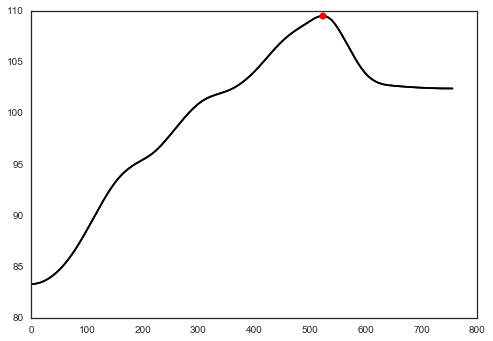

In [34]:
X5 = X4 - IMF5
plt.plot(dummy_t, X5, color='k')

print(sp.signal.argrelmin(X5))
print(sp.signal.argrelmax(X5))
plt.plot(dummy_t, X5, 'k')
plt.plot(dummy_t[[523]], X5[[523]], linewidth=0, marker='o', color='r')
print(X5.shape)

We now have just one maxima left (though it looks like we're close to a minima at the start date getting there with the max date). So we'll consider this as the residue.

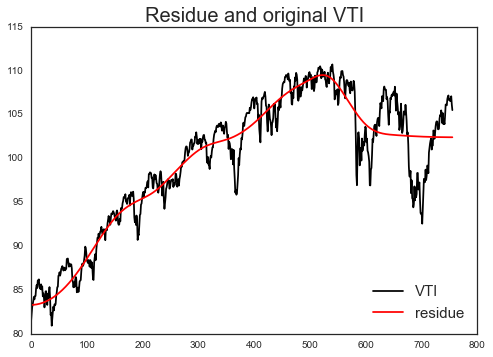

In [37]:
residue = X5
plt.plot(dummy_t, X0, color='k', label="VTI")
plt.plot(dummy_t, residue, color='r', label="residue")
plt.legend(fontsize=15, loc=4)
plt.title("Residue and original VTI", fontsize=20)

Plotting everything:

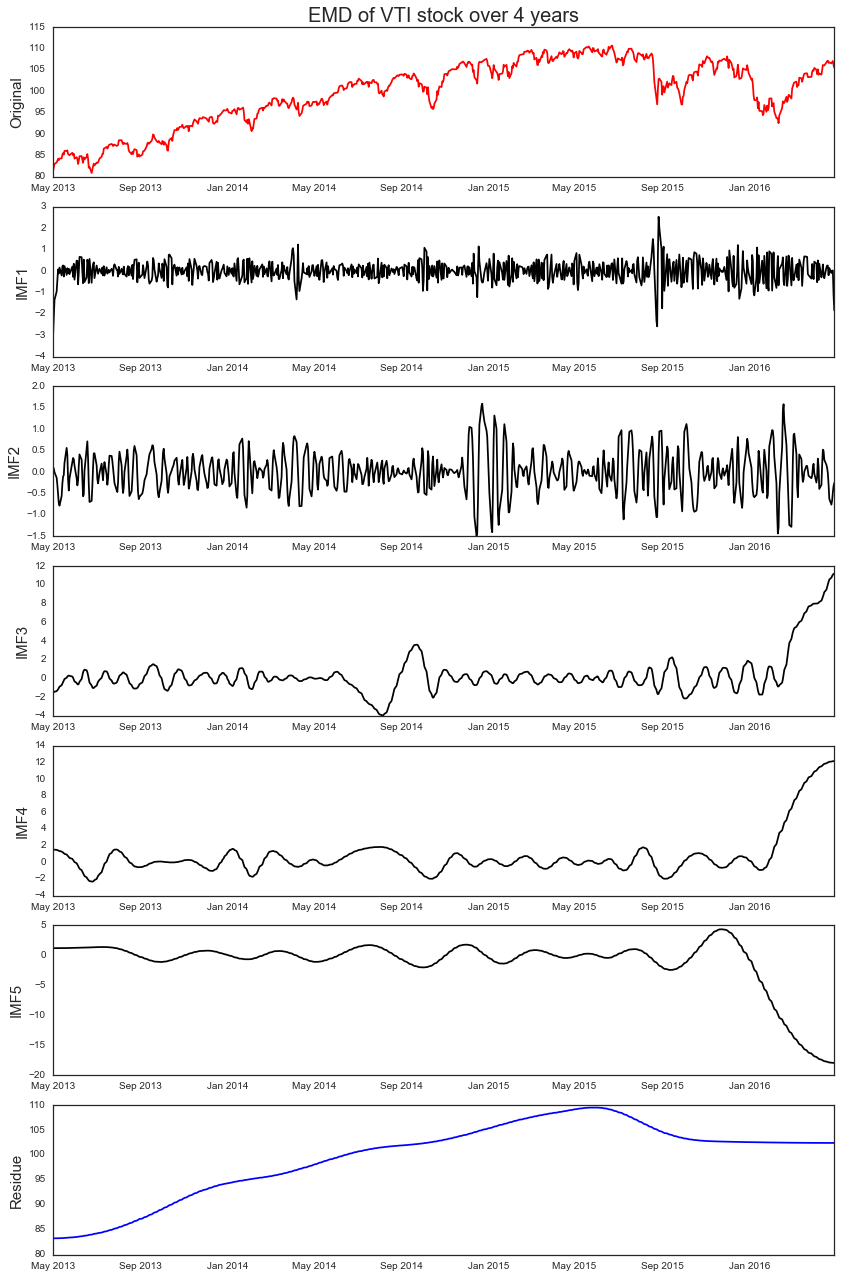

In [57]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14,22))
axes[0].plot(vti_dates, X0, color='r')
axes[0].set_ylabel("Original", fontsize=15)
axes[0].set_title("EMD of VTI stock over 4 years", fontsize=20)
axes[1].plot(vti_dates, IMF1, color='k')
axes[1].set_ylabel(r"IMF1", fontsize=15)

axes[2].plot(vti_dates, IMF2, color='k')
axes[2].set_ylabel(r"IMF2", fontsize=15)

axes[3].plot(vti_dates, IMF3, color='k')
axes[3].set_ylabel(r"IMF3", fontsize=15)

axes[4].plot(vti_dates, IMF4, color='k')
axes[4].set_ylabel(r"IMF4", fontsize=15)

axes[5].plot(vti_dates, IMF5, color='k')
axes[5].set_ylabel(r"IMF5", fontsize=15)

axes[6].plot(vti_dates, residue, color='b')
axes[6].set_ylabel(r"Residue", fontsize=15)


At this point the performance of VTI stock has been broken into 5 Hilbert-able frequency components.

Getting the frequency components...

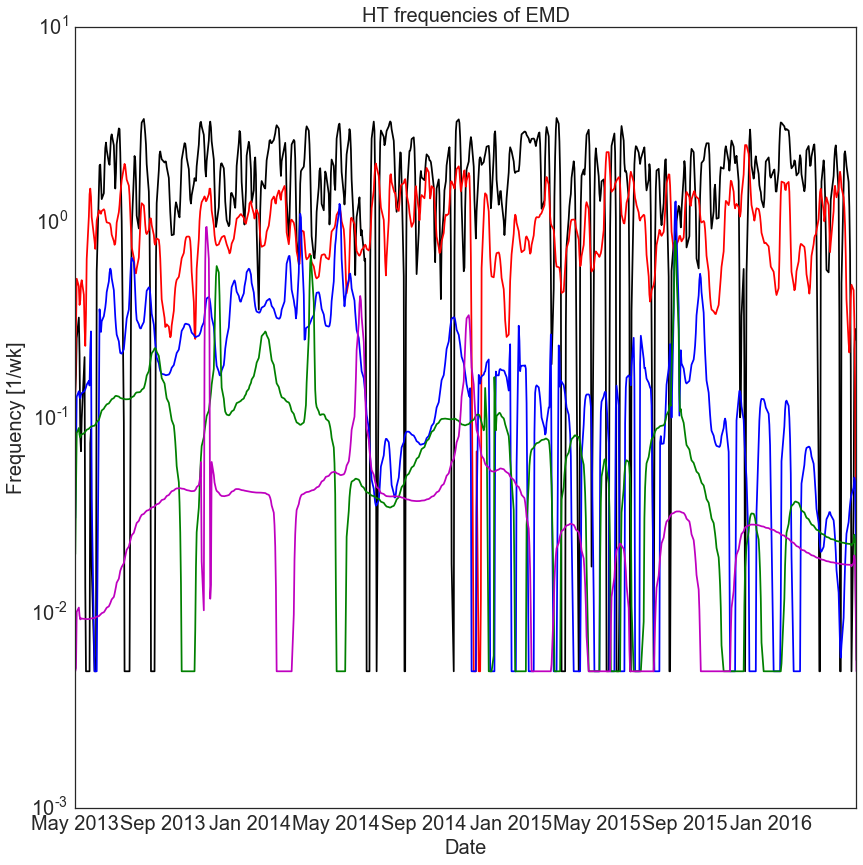

In [61]:
IMF_hil = mirror_hilbert(IMF1, reflect_x=False)

env1 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq1 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
# delta = 1 day. I'm going to multiply by 7 to get weekly freqs for something a bit
# more human readable

# The Hilbert signal we're getting here jumps below 0 at some times still. For this,
# we clip below min_freq_thresh
min_freq_thresh = 0.005
# Trying to clean out more weird bits, I'm use one final SG filter to clean out neg signals
freq1 = savgol_filter(freq1, 7, 3, deriv=0, mode='mirror')
freq1[freq1 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF2, reflect_x=False)

env2 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq2 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
freq2 = savgol_filter(freq2, 5, 3, deriv=0, mode='mirror')
freq2[freq2 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF3, reflect_x=False)

env3 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq3 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
freq3 = savgol_filter(freq3, 5, 3, deriv=0, mode='mirror')
freq3[freq3 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF4, reflect_x=False)

env4 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq4 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
freq4 = savgol_filter(freq4, 5, 3, deriv=0, mode='mirror')
freq4[freq4 < min_freq_thresh] = min_freq_thresh

IMF_hil = mirror_hilbert(IMF5, reflect_x=False)

env5 = np.abs(IMF_hil)
phase = np.unwrap(np.angle(IMF_hil))
phase = savgol_filter(phase, 7, 3, deriv=0, mode='mirror')
freq5 = 7*savgol_filter(phase, 5, 3, deriv=1, delta=1, mode='mirror')/(2*np.pi)
freq5 = savgol_filter(freq5, 5, 3, deriv=0, mode='mirror')
freq5[freq5 < min_freq_thresh] = min_freq_thresh

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
axes.semilogy(vti_dates, freq1, color='k', label='IMF1')
axes.semilogy(vti_dates, freq2, color='r', label='IMF2')
axes.semilogy(vti_dates, freq3, color='b', label='IMF3')
axes.semilogy(vti_dates, freq4, color='g', label='IMF4')
axes.semilogy(vti_dates, freq5, color='m', label='IMF5')
axes.set_xlabel("Date", fontsize=20)
axes.set_ylabel("Frequency [1/wk]", fontsize=20)
axes.set_title("HT frequencies of EMD", fontsize=20)
axes.tick_params(labelsize=20)

### Another example

LIGO [just came out with some fancy results](http://www.ligo.org/science/Publication-GW150914/index.php), showing the first directly observed black-hole merger. Exciting! Like pretty much everyone else, they chose to display their data in a spectrogram, whereas I think this would be a prime case for applying the HHT.

The data below can be downloaded [here](https://losc.ligo.org/s/events/GW150914/P150914/fig1-observed-H.txt).

In [ ]:
LIGO = np.loadtxt('LIGOdata.txt')
LIGO_x = LIGO[:-1, 0] # I'm dropping the last datapoint to get something more compound
LIGO_y = LIGO[:-1, 1]

In [ ]:
plt.plot(LIGO_x, LIGO_y, color='k')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel(r"Strain [$10^{-21}$]", fontsize=20)
plt.tick_params(labelsize=20)
plt.ylim([-1.5, 1.5])
plt.title("LIGO data", fontsize=20)

In [ ]:
### Routine for extending LIGO_x and LIGO_y
def mirror_xy(x, y, Next=500):
    N = len(x)
    x_extend = np.empty(N + 2*Next)
    y_extend = np.empty(N + 2*Next)
    dx = x[1] - x[0]
    negx = -np.arange(Next + 1, 1, -1)*dx + x[0]
    posx = np.arange(1, Next + 1)*dx + x[-1]
    x_extend[:Next] = negx
    x_extend[Next:(Next+N)] = x
    x_extend[(Next+N):] = posx
    y_extend[:Next] = y[(Next - 1)::-1]
    y_extend[Next:(Next+N)] = y
    y_extend[(Next+N):] = y[-1:-(Next + 1):-1]
    return x_extend, y_extend

In [ ]:
LIGO2_x, LIGO2_y = mirror_xy(LIGO_x, LIGO_y)

In [ ]:
# Calculating the first intrinsic mode function, we first find the minima

minima = sp.signal.argrelmin(LIGO2_y)
maxima = sp.signal.argrelmax(LIGO2_y)

minima_y = LIGO2_y[minima]
minima_x = LIGO2_x[minima]

maxima_y = LIGO2_y[maxima]
maxima_x = LIGO2_x[maxima]

minima_mask = np.logical_and(minima_x >= min(LIGO_x), minima_x <= max(LIGO_x))
maxima_mask = np.logical_and(maxima_x >= min(LIGO_x), maxima_x <= max(LIGO_x))

min_spline = sp.interpolate.interp1d(minima_x, minima_y, kind='cubic', fill_value=np.nan)
max_spline = sp.interpolate.interp1d(maxima_x, maxima_y, kind='cubic', fill_value=np.nan)

plt.plot(LIGO_x, LIGO_y, color='k', label='data')
plt.plot(minima_x[minima_mask], minima_y[minima_mask], color='r', linewidth=0, marker='o')
plt.plot(maxima_x[maxima_mask], maxima_y[maxima_mask], color='b', linewidth=0, marker='o')
plt.plot(LIGO_x, min_spline(LIGO_x), color='r', linestyle=":", linewidth=2, label='minima')
plt.plot(LIGO_x, max_spline(LIGO_x), color='b', linestyle=":", linewidth=2, label='maxima')
plt.fill_between(LIGO_x, min_spline(LIGO_x), max_spline(LIGO_x), color='k', alpha=0.2)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel(r"Strain [$10^{-21}$]", fontsize=20)
plt.legend(fontsize=15)
plt.tick_params(labelsize=20)
plt.ylim([-1.5, 1.5])
plt.title("LIGO data", fontsize=20)

In [ ]:
# We subtract out the mean of the two minima/maxima
m1 = (max_spline(LIGO_x) + min_spline(LIGO_x))/2
h1 = LIGO_y - m1

plt.plot(LIGO_x, h1, color='k')

In [ ]:
# We try this whole process again, trying to make the signal more Hilbertable.

h1x, h1y = mirror_xy(LIGO_x, h1)

minima = sp.signal.argrelmin(h1y)
maxima = sp.signal.argrelmax(h1y)

minima_y = h1y[minima]
minima_x = h1x[minima]

maxima_y = h1y[maxima]
maxima_x = h1x[maxima]

min_spline = sp.interpolate.interp1d(minima_x, minima_y, kind='cubic', fill_value=np.nan)
max_spline = sp.interpolate.interp1d(maxima_x, maxima_y, kind='cubic', fill_value=np.nan)

m11 = (max_spline(LIGO_x) + min_spline(LIGO_x))/2

h11 = h1 - m11

In [ ]:
plt.plot(LIGO_x, h1, color='k', label=r'$h_{1,0}$')
plt.plot(LIGO_x, h11, color='r', label=r'$h_{1,1}$')
plt.legend(fontsize=15)
plt.title("First refinement", fontsize=20)

In [ ]:
h11x, h11y = mirror_xy(LIGO_x, h11)

minima = sp.signal.argrelmin(h11y)
maxima = sp.signal.argrelmax(h11y)

minima_y = h11y[minima]
minima_x = h11x[minima]

maxima_y = h11y[maxima]
maxima_x = h11x[maxima]

min_spline = sp.interpolate.interp1d(minima_x, minima_y, kind='cubic', fill_value=np.nan)
max_spline = sp.interpolate.interp1d(maxima_x, maxima_y, kind='cubic', fill_value=np.nan)

m12 = (max_spline(LIGO_x) + min_spline(LIGO_x))/2

h12 = h11 - m12

In [ ]:
plt.plot(LIGO_x, h11, color='k', label=r'$h_{1,1}$')
plt.plot(LIGO_x, h12, color='r', label=r'$h_{1,2}$')
plt.legend(fontsize=15)
plt.title("Second refinement", fontsize=20)

In [ ]:
h12x, h12y = mirror_xy(LIGO_x, h12)

minima = sp.signal.argrelmin(h12y)
maxima = sp.signal.argrelmax(h12y)

minima_y = h12y[minima]
minima_x = h12x[minima]

maxima_y = h12y[maxima]
maxima_x = h12x[maxima]

min_spline = sp.interpolate.interp1d(minima_x, minima_y, kind='cubic', fill_value=np.nan)
max_spline = sp.interpolate.interp1d(maxima_x, maxima_y, kind='cubic', fill_value=np.nan)

m13 = (max_spline(LIGO_x) + min_spline(LIGO_x))/2

h13 = h12 - m13

In [ ]:
plt.plot(LIGO_x, h12, color='k', label=r'$h_{1,2}$')
plt.plot(LIGO_x, h13, color='r', label=r'$h_{1,3}$')
plt.legend(fontsize=15)
plt.title("Third refinement", fontsize=20)

In [ ]:
h13x, h13y = mirror_xy(LIGO_x, h13)

minima = sp.signal.argrelmin(h13y)
maxima = sp.signal.argrelmax(h13y)

minima_y = h13y[minima]
minima_x = h13x[minima]

maxima_y = h13y[maxima]
maxima_x = h13x[maxima]

min_spline = sp.interpolate.interp1d(minima_x, minima_y, kind='cubic', fill_value=np.nan)
max_spline = sp.interpolate.interp1d(maxima_x, maxima_y, kind='cubic', fill_value=np.nan)

m14 = (max_spline(LIGO_x) + min_spline(LIGO_x))/2

h14 = h13 - m14

In [ ]:
plt.plot(LIGO_x, h13, color='k', label=r'$h_{1,3}$')
plt.plot(LIGO_x, h14, color='r', label=r'$h_{1,4}$')
plt.legend(fontsize=15)
plt.title("Fourth refinement", fontsize=20)

I'd probably run the cycle a few more times (S rule) but $h_{1,4}$ is a pretty decent value for the first IMF. At this point, we subtract out the signal, and start to rerun the process.

In [ ]:
X2 = LIGO_y - h14
IMF1 = h14

plt.plot(LIGO_x, X2, color='k')
plt.title("Signal minus first IMF", fontsize=20)

In [ ]:
def HHT_IMF_prototype(x, y, Niter=5, Next=500):
    N = len(x)
    out_y = np.zeros((N, Niter))
    for idx in range(Niter):
        print('Running %d of %d' % (idx + 1, Niter))
        ext_x, ext_y = mirror_xy(x, y, Next=Next)
        minima = sp.signal.argrelmin(ext_y)
        maxima = sp.signal.argrelmax(ext_y)        
        minima_y = ext_y[minima]
        minima_x = ext_x[minima]
        maxima_y = ext_y[maxima]
        maxima_x = ext_x[maxima]
        min_spline = sp.interpolate.interp1d(minima_x, minima_y, kind='cubic', fill_value=np.nan)
        max_spline = sp.interpolate.interp1d(maxima_x, maxima_y, kind='cubic', fill_value=np.nan)
        env_mean = (min_spline(x) + max_spline(x))/2
        y = y - env_mean
        out_y[:, idx] = y
    return out_y

In [ ]:
h2_series = HHT_IMF_prototype(LIGO_x, X2, Niter=4)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14,14))
axes[0].plot(LIGO_x, h2_series[:,0], color='r', label='new')
axes[0].plot(LIGO_x, X2, color='k', label='old')
axes[0].legend(fontsize=15)
axes[1].plot(LIGO_x, h2_series[:,1], color='r', label='new')
axes[1].plot(LIGO_x, h2_series[:,0], color='k', label='old')
axes[1].legend(fontsize=15)
axes[2].plot(LIGO_x, h2_series[:,2], color='r', label='new')
axes[2].plot(LIGO_x, h2_series[:,1], color='k', label='old')
axes[2].legend(fontsize=15)
axes[3].plot(LIGO_x, h2_series[:,3], color='r', label='new')
axes[3].plot(LIGO_x, h2_series[:,2], color='k', label='old')
axes[3].legend(fontsize=15)

In [ ]:
IMF2 = h2_series[:,3]
X3 = X2 - IMF2

plt.plot(LIGO_x, X3, color='k')

In [ ]:
h3_series = HHT_IMF_prototype(LIGO_x, X3, Niter=4)
# Niter = 4 done by inspection by eye

IMF3 = h3_series[:,3]
X4 = X3 - IMF3

In [ ]:
plt.plot(LIGO_x, X4, color='k')

In [ ]:
h4_series = HHT_IMF_prototype(LIGO_x, X4, Niter=10, Next=3000)

# fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14,14))
# axes[0].plot(LIGO_x, h4_series[:,0], color='r', label='new')
# axes[0].plot(LIGO_x, X4, color='k', label='old')
# axes[0].legend(fontsize=15)
# axes[1].plot(LIGO_x, h4_series[:,3], color='r', label='new')
# axes[1].plot(LIGO_x, h4_series[:,2], color='k', label='old')
# axes[1].legend(fontsize=15)
# axes[2].plot(LIGO_x, h4_series[:,5], color='r', label='new')
# axes[2].plot(LIGO_x, h4_series[:,4], color='k', label='old')
# axes[2].legend(fontsize=15)
# axes[3].plot(LIGO_x, h4_series[:,7], color='r', label='new')
# axes[3].plot(LIGO_x, h4_series[:,6], color='k', label='old')
# axes[3].legend(fontsize=15)
# axes[4].plot(LIGO_x, h4_series[:,9], color='r', label='new')
# axes[4].plot(LIGO_x, h4_series[:,8], color='k', label='old')
# axes[4].legend(fontsize=15)

In [ ]:
IMF4 = h4_series[:,-1]
X5 = X4 - IMF4

plt.plot(LIGO_x, X5, color='k')

In [ ]:
h5_series = HHT_IMF_prototype(LIGO_x, X5, Niter=5, Next=3000)

# fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14,14))
# axes[0].plot(LIGO_x, h4_series[:,0], color='r', label='new')
# axes[0].plot(LIGO_x, X4, color='k', label='old')
# axes[0].legend(fontsize=15)
# axes[1].plot(LIGO_x, h4_series[:,1], color='r', label='new')
# axes[1].plot(LIGO_x, h4_series[:,0], color='k', label='old')
# axes[1].legend(fontsize=15)
# axes[2].plot(LIGO_x, h4_series[:,2], color='r', label='new')
# axes[2].plot(LIGO_x, h4_series[:,1], color='k', label='old')
# axes[2].legend(fontsize=15)
# axes[3].plot(LIGO_x, h4_series[:,3], color='r', label='new')
# axes[3].plot(LIGO_x, h4_series[:,2], color='k', label='old')
# axes[3].legend(fontsize=15)
# axes[4].plot(LIGO_x, h4_series[:,4], color='r', label='new')
# axes[4].plot(LIGO_x, h4_series[:,3], color='k', label='old')
# axes[4].legend(fontsize=15)

In [ ]:
IMF5 = h5_series[:,-1]
X6 = X5 - IMF5

plt.plot(LIGO_x, X6, color='k')

In [ ]:
h6_series = HHT_IMF_prototype(LIGO_x, X6, Niter=5, Next=3400)

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(14,14))
axes[0].plot(LIGO_x, LIGO_y, color='k')
axes[0].set_ylabel("Signal", fontsize=15)
axes[1].plot(LIGO_x, IMF1, color='k')

axes[2].plot(LIGO_x, IMF2, color='k')

axes[3].plot(LIGO_x, IMF3, color='k')

axes[4].plot(LIGO_x, IMF4, color='k')

axes[5].plot(LIGO_x, IMF5, color='k')

### An application to financial data

Going through the paper [Application of Hilbert-Huang transform to non-stationary financial time series analysis](https://web.cs.dal.ca/~tt/CSCI690611/papers/plugin-huan_asmbi_2003.pdf)

https://cds.cern.ch/record/1115835?ln=no

http://www.msri.org/people/members/2008cc/Projects/Project_5B_Ice_Core_EMD/HuangWu_EMD_RevGeo_2008.pdf

https://cran.r-project.org/web/packages/hht/index.html

https://pyhht.readthedocs.org/en/latest/

https://losc.ligo.org/s/events/GW150914/P150914/fig1-observed-H.txt